In [1]:
#import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from scipy.stats import uniform, randint
from collections import Counter
import joblib
import pickle
import warnings
warnings.filterwarnings('ignore')


In [2]:
data1 = pd.read_csv("Train new.csv")
data1

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10994,10995,A,Ship,4,1,252,5,medium,F,1,1538,1
10995,10996,B,Ship,4,1,232,5,medium,F,6,1247,0
10996,10997,C,Ship,5,4,242,5,low,F,4,1155,0
10997,10998,F,Ship,5,2,223,6,medium,M,2,1210,0


In [3]:

data1.info()
data1.drop(columns='ID', inplace=True)
data1.shape
data1.head()
data1.describe(include='all')
data1.isnull().sum()
data1.columns.tolist()
data1.nunique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


Warehouse_block           5
Mode_of_Shipment          3
Customer_care_calls       6
Customer_rating           5
Cost_of_the_Product     215
Prior_purchases           8
Product_importance        3
Gender                    2
Discount_offered         65
Weight_in_gms          4034
Reached.on.Time_Y.N       2
dtype: int64

In [4]:
# Check for duplicate rows
duplicates = data1.duplicated().sum()
print("Number of duplicate rows:", duplicates)

# If duplicates exist, remove them
data1 = data1.drop_duplicates()


Number of duplicate rows: 0


In [5]:
counts = data1['Reached.on.Time_Y.N'].value_counts()
print(counts)

Reached.on.Time_Y.N
1    6563
0    4436
Name: count, dtype: int64


In [6]:
for col in data1.columns:
    if data1[col].dtype=='object':
        print(f"{col} has {data1[col].unique()} unique values")
    else:
        print(f"{col} has {data1[col].nunique()} unique values")
    print("*"*10)


Warehouse_block has ['D' 'F' 'A' 'B' 'C'] unique values
**********
Mode_of_Shipment has ['Flight' 'Ship' 'Road'] unique values
**********
Customer_care_calls has 6 unique values
**********
Customer_rating has 5 unique values
**********
Cost_of_the_Product has 215 unique values
**********
Prior_purchases has 8 unique values
**********
Product_importance has ['low' 'medium' 'high'] unique values
**********
Gender has ['F' 'M'] unique values
**********
Discount_offered has 65 unique values
**********
Weight_in_gms has 4034 unique values
**********
Reached.on.Time_Y.N has 2 unique values
**********


In [7]:
x2=data1.loc[data1["Product_importance"] == "high", "Reached.on.Time_Y.N"].mean() * 100
print(f"{x2:.2f}% of high importance products were not delivered on time.")
x1=data1.loc[data1["Product_importance"] == "medium", "Reached.on.Time_Y.N"].mean() * 100
print(f"{x1:.2f}% of medium importance products were not delivered on time.")
x3=data1.loc[data1["Product_importance"] == "low", "Reached.on.Time_Y.N"].mean() * 100
print(f"{x3:.2f}% of low importance products were not delivered on time.")
print('High important products seem to have the lowest delivery rate')


64.98% of high importance products were not delivered on time.
59.05% of medium importance products were not delivered on time.
59.28% of low importance products were not delivered on time.
High important products seem to have the lowest delivery rate


# Univariate analysis for categorical columns and numerical variables

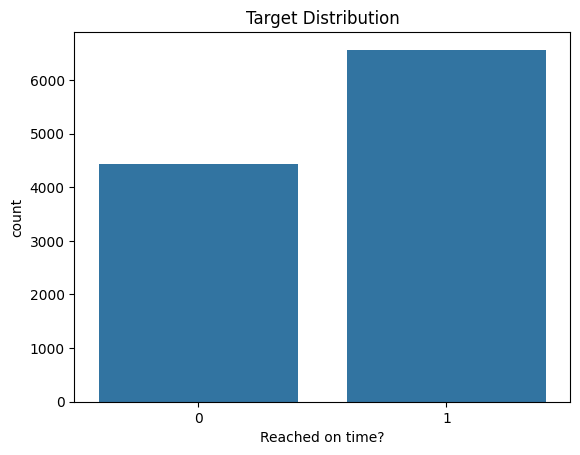

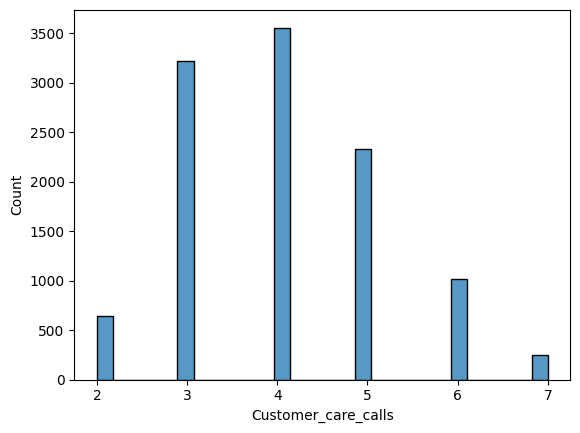

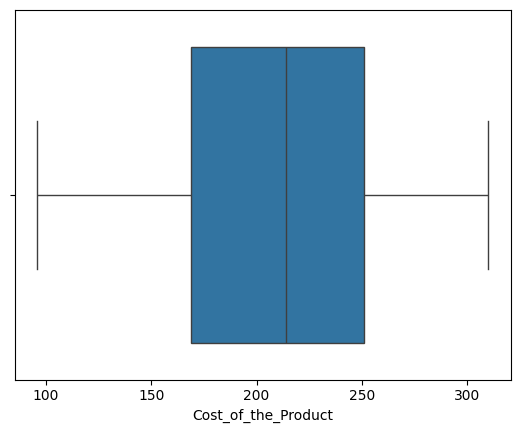

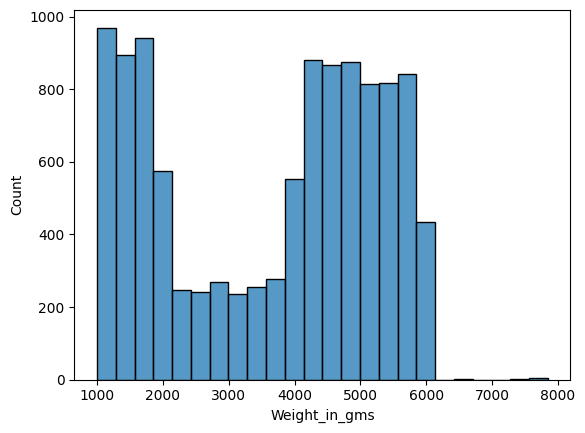

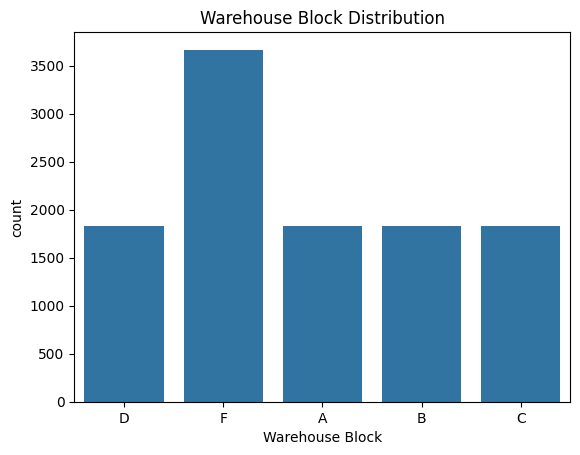

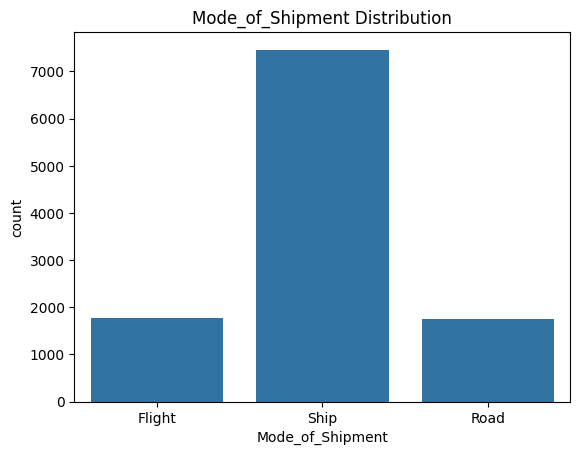

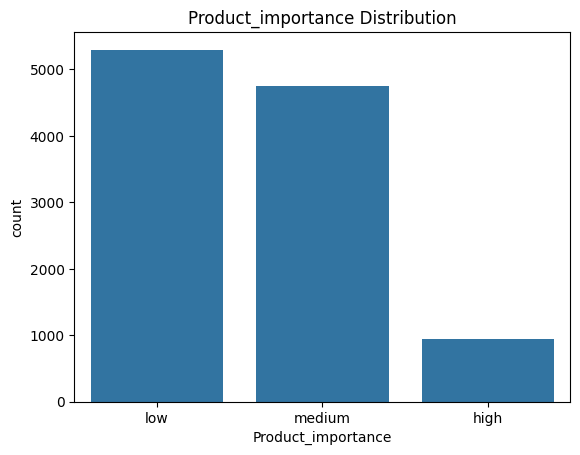

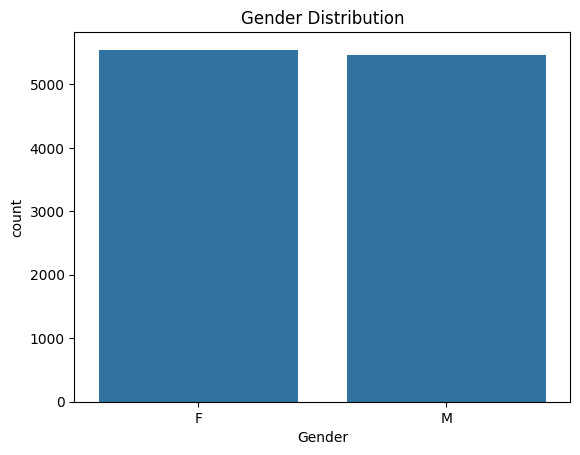

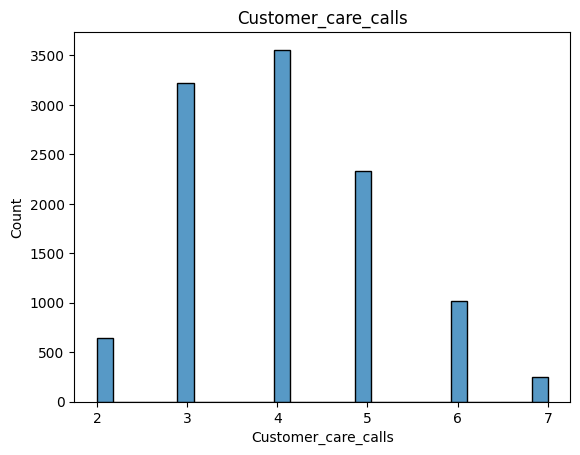

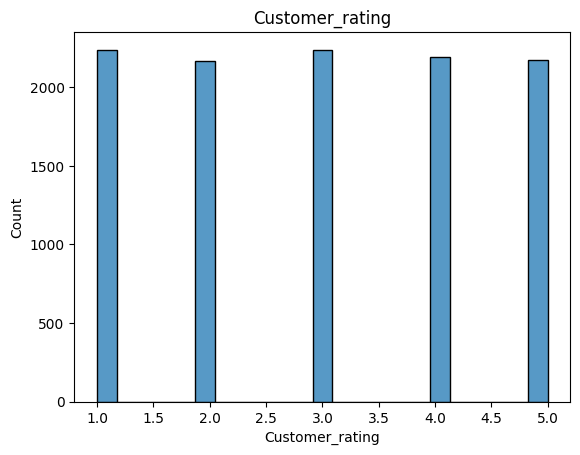

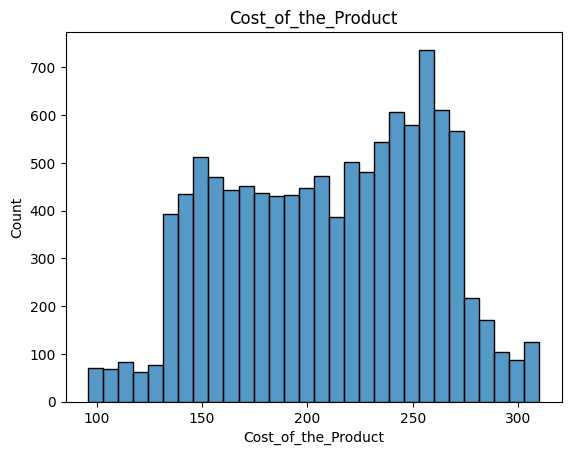

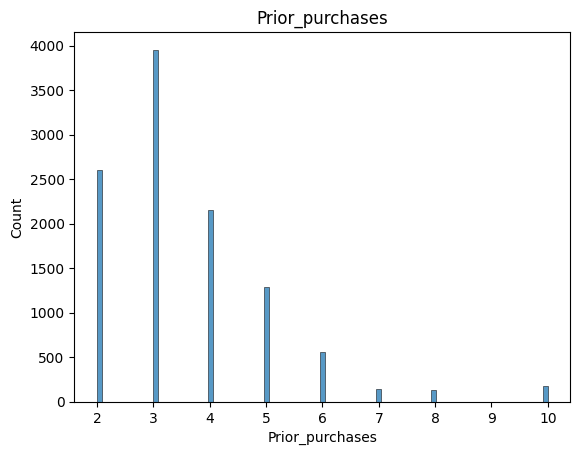

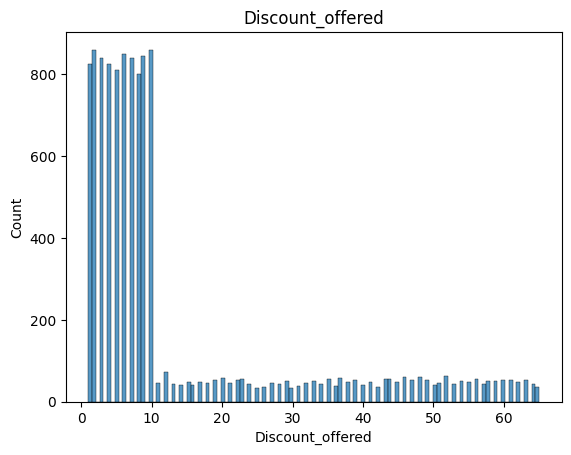

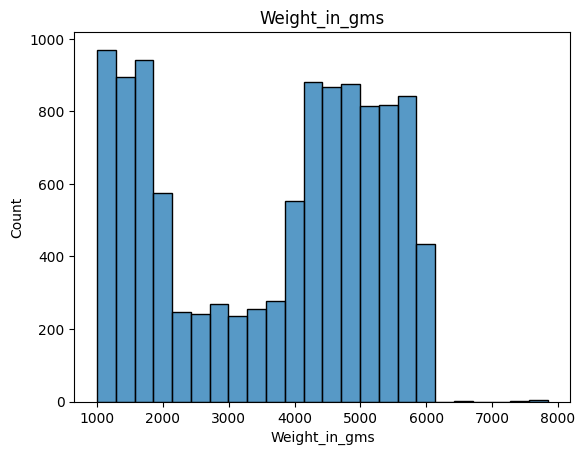

In [8]:
#Target Distribution
sns.countplot(x='Reached.on.Time_Y.N',data=data1)
plt.title('Target Distribution')
plt.xlabel('Reached on time?')
plt.show()
sns.histplot(data1["Customer_care_calls"])
plt.show()
sns.boxplot(x=data1["Cost_of_the_Product"])
plt.show()
sns.histplot(data1["Weight_in_gms"])
plt.show()
sns.countplot(x='Warehouse_block', data=data1)
plt.title('Warehouse Block Distribution')
plt.xlabel('Warehouse Block')
plt.show()
sns.countplot(x='Mode_of_Shipment', data=data1)
plt.title('Mode_of_Shipment Distribution')
plt.xlabel('Mode_of_Shipment')
plt.show()
sns.countplot(x='Product_importance', data=data1)
plt.title('Product_importance Distribution')
plt.xlabel('Product_importance')
plt.show()
sns.countplot(x='Gender', data=data1)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.show()
# Univariate analysis for numerical columns

cols = ['Customer_care_calls','Customer_rating','Cost_of_the_Product','Prior_purchases','Discount_offered','Weight_in_gms']
for z in cols:
    sns.histplot(data1[z])
    plt.title(z)
    plt.show()


# Bivariate Analysis: Relationship between two columns


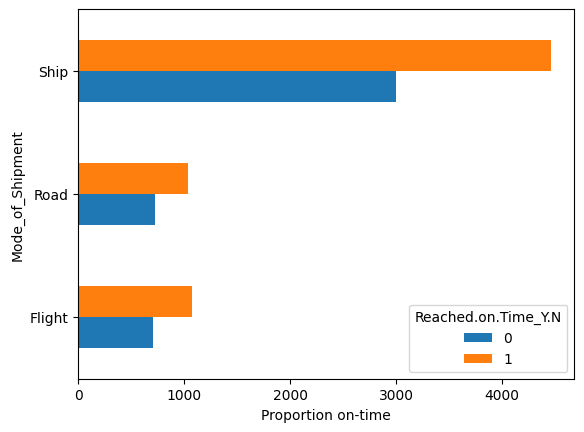

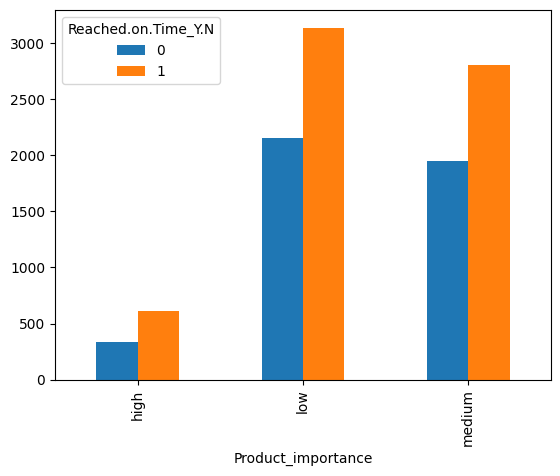

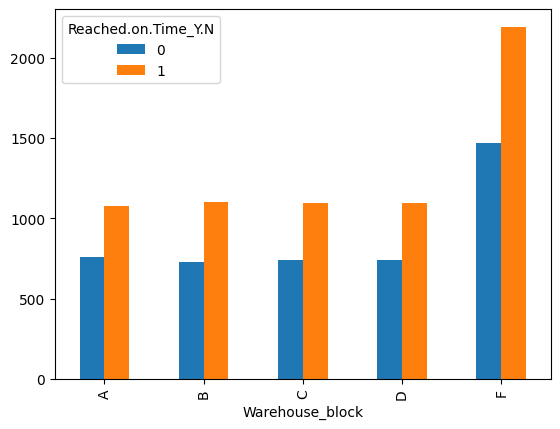

In [9]:
s = pd.crosstab(data1['Mode_of_Shipment'],data1['Reached.on.Time_Y.N'])
s.plot(kind='barh')
plt.xlabel('Proportion on-time')
plt.show()

t = pd.crosstab(data1['Product_importance'],data1['Reached.on.Time_Y.N'])
t.plot(kind='bar')
plt.show()

r = pd.crosstab(data1['Warehouse_block'],data1['Reached.on.Time_Y.N'])
r.plot(kind='bar')
plt.show()


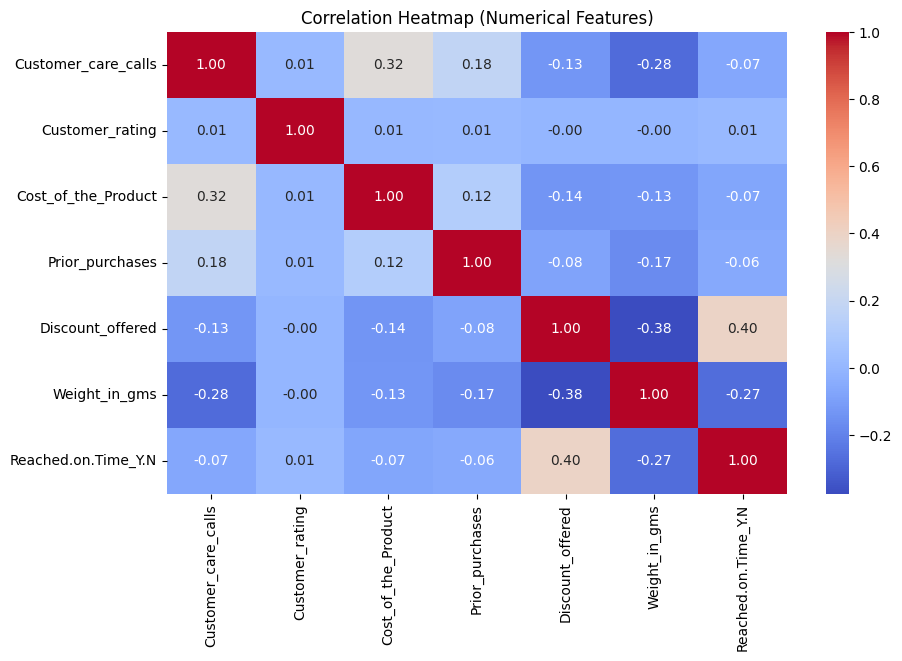

In [10]:
# Correlation heatmap for numerical features
plt.figure(figsize=(10,6))
corr = data1[cols + ['Reached.on.Time_Y.N']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()


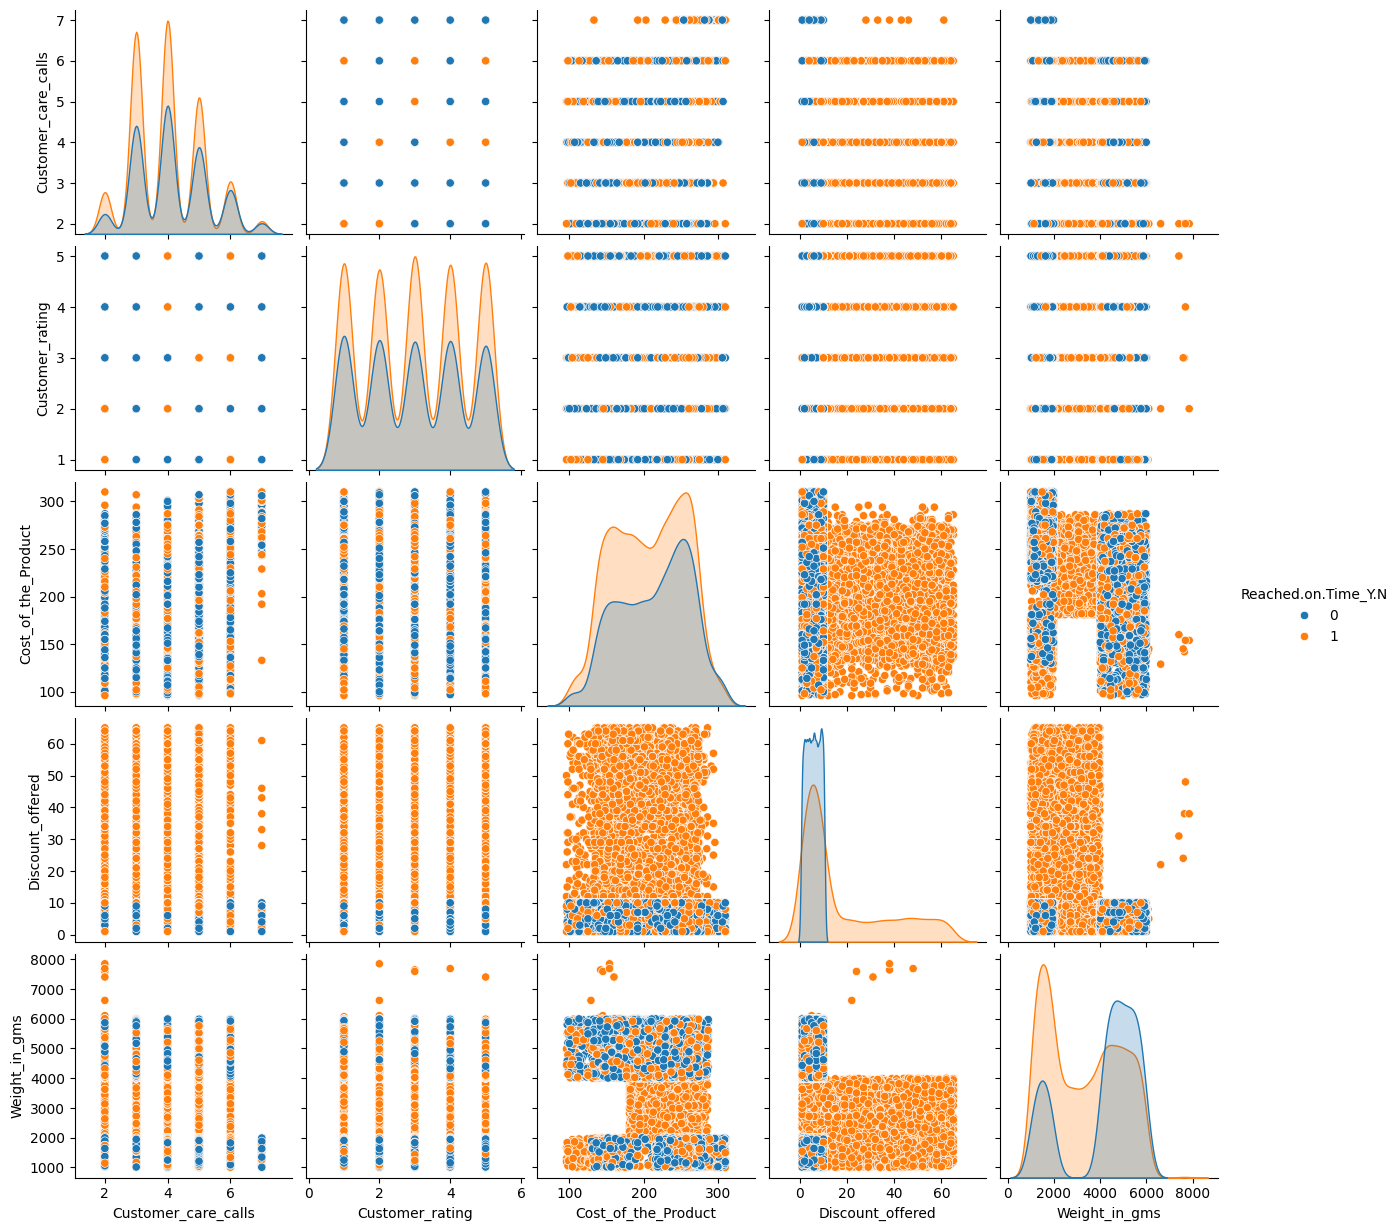

In [11]:
# Pairplot: shows scatter plots + histograms together
sns.pairplot(data1[['Customer_care_calls','Customer_rating',
                    'Cost_of_the_Product','Discount_offered',
                    'Weight_in_gms','Reached.on.Time_Y.N']],
             hue='Reached.on.Time_Y.N')
plt.show()


Outlier Detection and removal

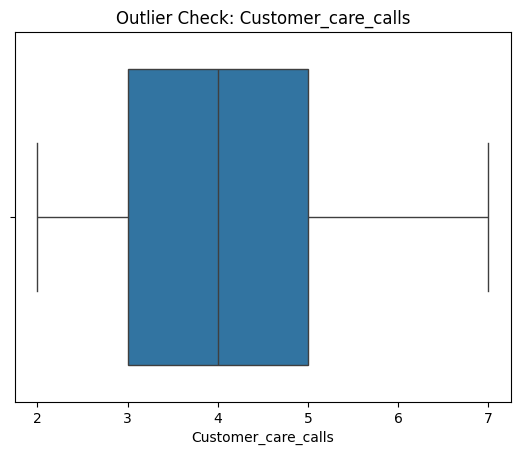

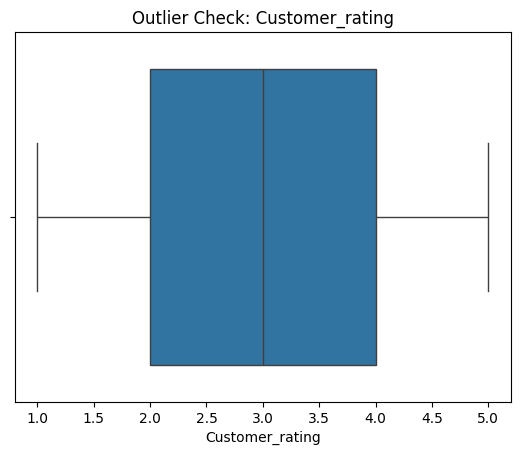

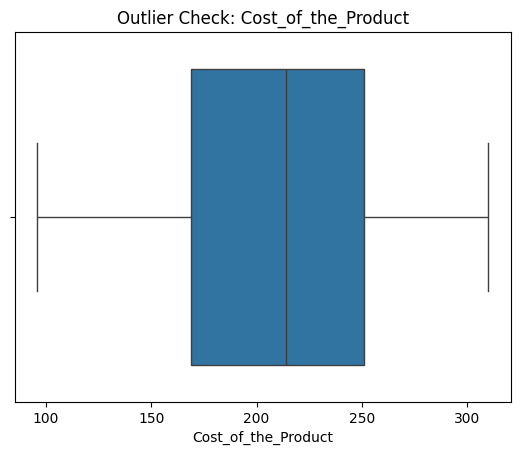

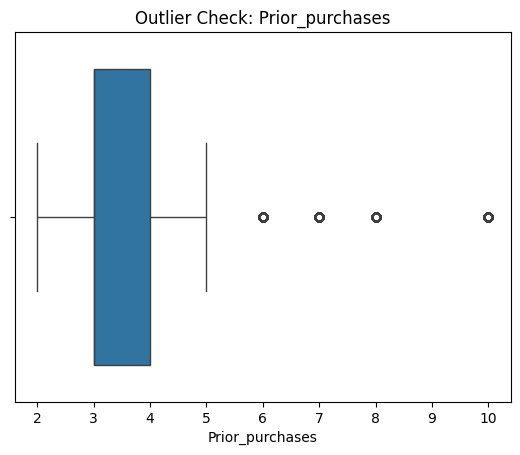

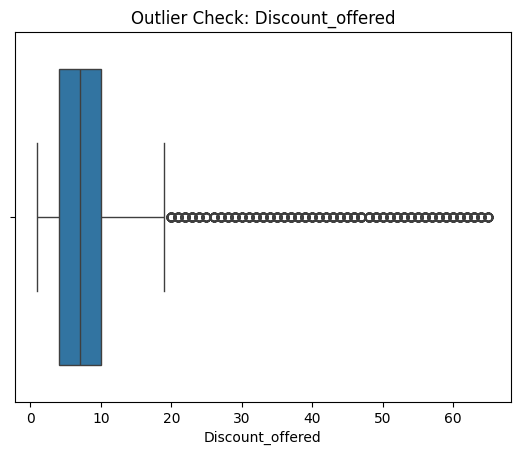

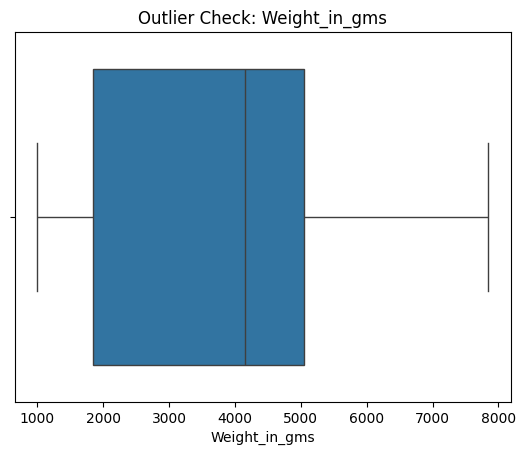

In [12]:
# Outlier detection using boxplots
for z in cols:
    sns.boxplot(x=data1[z])
    plt.title(f'Outlier Check: {z}')
    plt.show()


In [13]:
# Outlier Detection & Treatment using IQR

def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    before = data.shape[0]
    data = data[(data[column] >= lower) & (data[column] <= upper)]
    after = data.shape[0]
    print(f"{column}: {before - after} outliers removed")
    return data

cols_to_check = ['Prior_purchases', 'Discount_offered']
for col in cols_to_check:
    data1 = remove_outliers_iqr(data1, col)

print("\n Outlier treatment completed successfully!")


Prior_purchases: 1003 outliers removed
Discount_offered: 2025 outliers removed

 Outlier treatment completed successfully!


#  Preprocessing — Encoding + Feature Engineering + Scaling

Columns after encoding: ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms', 'Reached.on.Time_Y.N', 'Warehouse_block_B', 'Warehouse_block_C', 'Warehouse_block_D', 'Warehouse_block_F', 'Mode_of_Shipment_Road', 'Mode_of_Shipment_Ship']


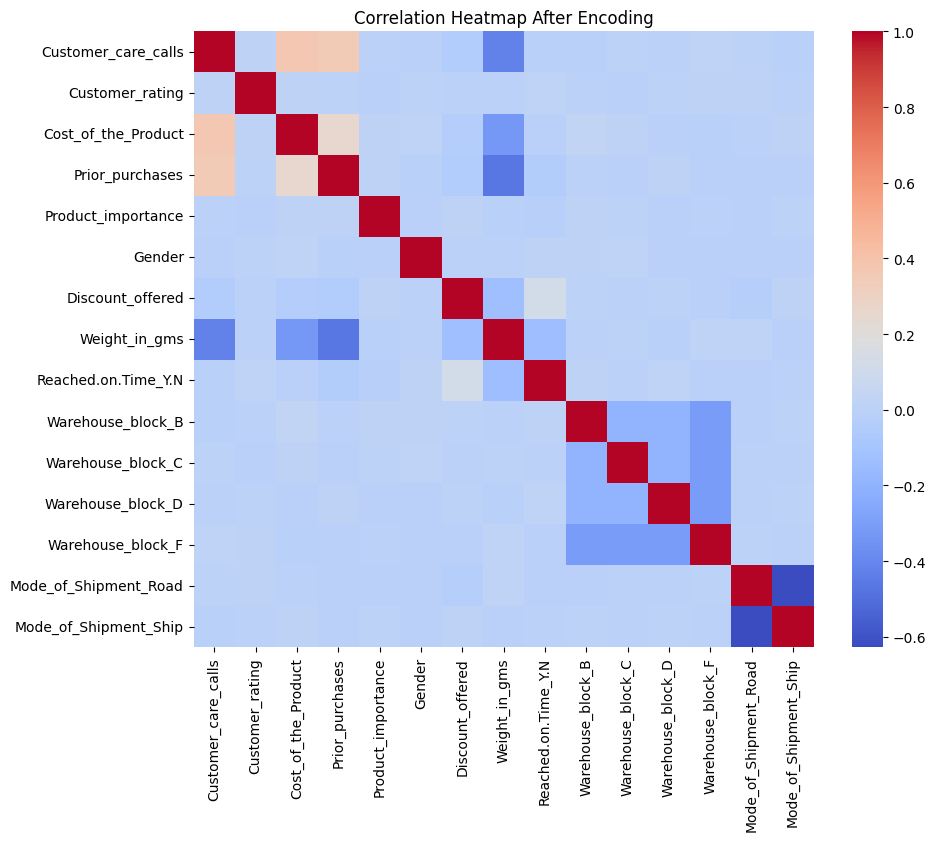

In [14]:
# Label encoding and one hot encoding and feature engineering


# Copy dataset
encode_data = data1.copy()

# Initialize LabelEncoder
le = LabelEncoder()

# Label Encode
encoders = {}  # dictionary to store encoders

for col in ['Product_importance', 'Gender']:
    le = LabelEncoder()
    encode_data[col] = le.fit_transform(encode_data[col])
    encoders[col] = le  # save encoder for later use

# One-Hot Encode nominal categorical columns
encode_data = pd.get_dummies(encode_data,
                             columns=['Warehouse_block', 'Mode_of_Shipment'],
                             drop_first=True)
print(f"Columns after encoding: {encode_data.columns.tolist()}")

# Check
encode_data.head()
plt.figure(figsize=(10,8))
sns.heatmap(encode_data.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap After Encoding")
plt.show()

# Step 3: Convert boolean columns to int
encode_data = encode_data.astype(int)


In [15]:
# Check only the encoded columns
encode_data[['Product_importance', 'Gender'] +
            [col for col in encode_data.columns if 'Warehouse_block' in col or 'Mode_of_Shipment' in col]].head()
# Convert all boolean columns to 0/1
encode_data = encode_data.astype(int)
encode_data.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Road,Mode_of_Shipment_Ship
3,3,3,176,4,2,1,10,1177,1,1,0,0,0,0,0
5,3,1,162,3,2,0,12,1417,1,0,0,0,1,0,0
6,3,4,250,3,1,0,3,2371,1,0,0,1,0,0,0
8,3,4,150,3,1,0,11,1861,1,0,0,0,0,0,0
10,3,4,189,2,2,1,12,2888,1,0,1,0,0,0,0



# Feature Engineering of Cost of the product & weight in grams
1.   handling the infinity and nan values
2.   filling nan values with the median values



In [16]:

encode_data['Cost_to_Weight_ratio'] = encode_data['Cost_of_the_Product'] / encode_data['Weight_in_gms']
encode_data['Cost*Weight'] = encode_data['Cost_of_the_Product'] * encode_data['Weight_in_gms']
encode_data['Discount_Ratio'] = encode_data['Discount_offered'] / encode_data['Cost_of_the_Product']

# Step 5: Handle infinity and NaN values
encode_data.replace([np.inf, -np.inf], np.nan, inplace=True)
encode_data['Cost_to_Weight_ratio'].fillna(encode_data['Cost_to_Weight_ratio'].median(), inplace=True)
encode_data['Discount_Ratio'].fillna(0, inplace=True)
encode_data.fillna(0, inplace=True)

print(f"Cost_to_Weight_ratio range: {encode_data['Cost_to_Weight_ratio'].min():.4f} to {encode_data['Cost_to_Weight_ratio'].max():.4f}")
print(f"Cost*Weight range: {encode_data['Cost*Weight'].min():.0f} to {encode_data['Cost*Weight'].max():.0f}")


Cost_to_Weight_ratio range: 0.0165 to 0.3091
Cost*Weight range: 106184 to 1713964


In [17]:
# Initialize and apply scaler
std_scaler = StandardScaler()

# Columns to normalize
num_cols = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product',
            'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
# Apply to numerical columns
std_scaled_data = encode_data.copy()
std_scaled_data[num_cols] = std_scaler.fit_transform(encode_data[num_cols])

# Check results
print(std_scaled_data[num_cols].describe())

print(encode_data.head(3))

       Customer_care_calls  Customer_rating  Cost_of_the_Product  \
count         7.971000e+03     7.971000e+03         7.971000e+03   
mean          2.567260e-16    -6.418150e-17        -5.705023e-17   
std           1.000063e+00     1.000063e+00         1.000063e+00   
min          -1.811352e+00    -1.410633e+00        -2.440190e+00   
25%          -9.621407e-01    -7.030530e-01        -8.436174e-01   
50%          -1.129298e-01     4.527235e-03         1.309140e-01   
75%           7.362811e-01     7.121075e-01         8.358942e-01   
max           2.434703e+00     1.419688e+00         1.997038e+00   

       Prior_purchases  Discount_offered  Weight_in_gms  
count     7.971000e+03      7.971000e+03   7.971000e+03  
mean      1.426256e-16     -7.131278e-17  -1.069692e-16  
std       1.000063e+00      1.000063e+00   1.000063e+00  
min      -1.293438e+00     -1.405797e+00  -1.825311e+00  
25%      -2.846323e-01     -8.420067e-01  -1.235852e+00  
50%      -2.846323e-01      3.677966e-0

In [18]:
# Confirm all columns are numeric
print("\nAll numeric columns?", encode_data.dtypes.apply(lambda x: x != 'object').all())
print("\nCost_to_Weight_ratio summary:\n", encode_data['Cost_to_Weight_ratio'].describe())

# Preview first few rows
encode_data.head()



All numeric columns? True

Cost_to_Weight_ratio summary:
 count    7971.000000
mean        0.076158
std         0.060799
min         0.016482
25%         0.036733
50%         0.047983
75%         0.096748
max         0.309073
Name: Cost_to_Weight_ratio, dtype: float64


,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Cost_to_Weight_ratio,Cost*Weight,Discount_Ratio
3,3,3,176,4,2,1,10,1177,1,1,0,0,0,0,0,0.149533,207152,0.056818
5,3,1,162,3,2,0,12,1417,1,0,0,0,1,0,0,0.114326,229554,0.074074
6,3,4,250,3,1,0,3,2371,1,0,0,1,0,0,0,0.105441,592750,0.012000
8,3,4,150,3,1,0,11,1861,1,0,0,0,0,0,0,0.080602,279150,0.073333
10,3,4,189,2,2,1,12,2888,1,0,1,0,0,0,0,0.065443,545832,0.063492


# Value Count


Target Variable (Reached.on.Time_Y.N):
Reached.on.Time_Y.N
0    4024
1    3947
Name: count, dtype: int64

Normalized Value Counts (Proportion):
Reached.on.Time_Y.N
0    0.50483
1    0.49517
Name: proportion, dtype: float64

Column: Warehouse_block
Warehouse_block
F    2625
A    1351
D    1342
C    1330
B    1323
Name: count, dtype: int64

Normalized:
Warehouse_block
F    0.329319
A    0.169489
D    0.168360
C    0.166855
B    0.165977
Name: proportion, dtype: float64

Column: Mode_of_Shipment
Mode_of_Shipment
Ship      5407
Flight    1308
Road      1256
Name: count, dtype: int64

Normalized:
Mode_of_Shipment
Ship      0.678334
Flight    0.164095
Road      0.157571
Name: proportion, dtype: float64

Column: Product_importance
Product_importance
low       3954
medium    3406
high       611
Name: count, dtype: int64

Normalized:
Product_importance
low       0.496048
medium    0.427299
high      0.076653
Name: proportion, dtype: float64

Column: Gender
Gender
F    3995
M    3976
Name: count

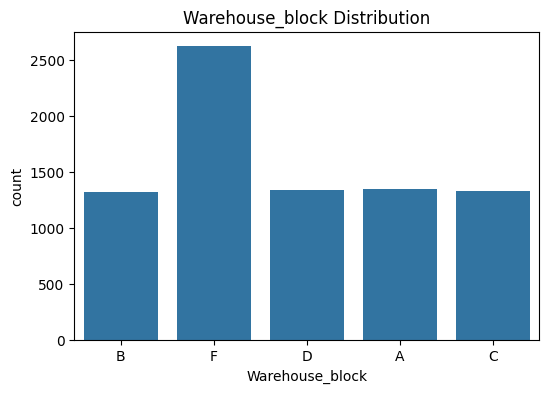

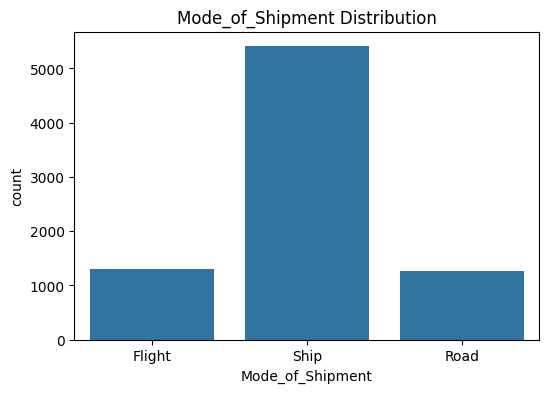

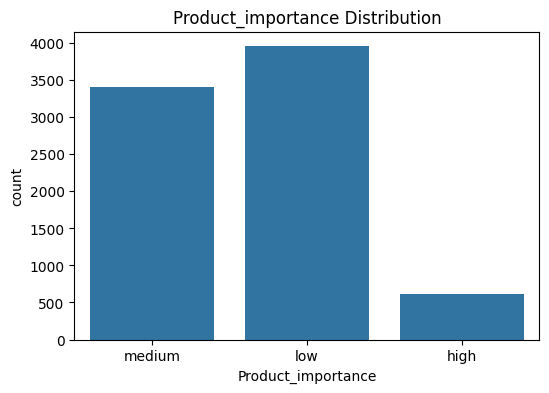

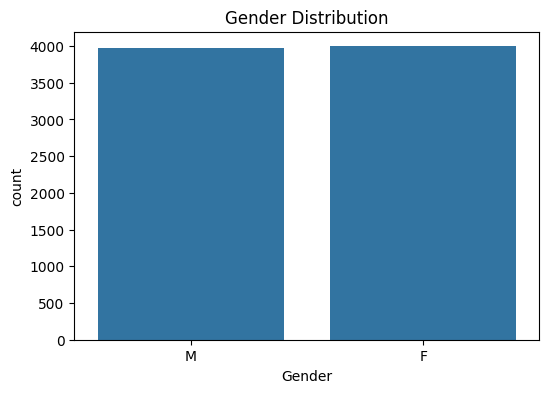

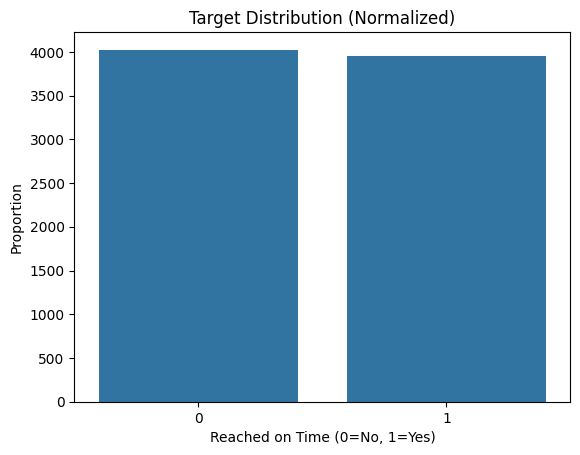

In [19]:
# For target column
print("Target Variable (Reached.on.Time_Y.N):")
print(data1['Reached.on.Time_Y.N'].value_counts())
print("\nNormalized Value Counts (Proportion):")
print(data1['Reached.on.Time_Y.N'].value_counts(normalize=True))
# For all categorical columns
categorical_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(data1[col].value_counts())
    print("\nNormalized:")
    print(data1[col].value_counts(normalize=True))

for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=data1)
    plt.title(f'{col} Distribution')
    plt.show()

encode_data.select_dtypes(include=['object']).columns
encode_data.dtypes
sns.countplot(x='Reached.on.Time_Y.N', data=data1)
plt.title('Target Distribution (Normalized)')
plt.xlabel('Reached on Time (0=No, 1=Yes)')
plt.ylabel('Proportion')
plt.show()


In [20]:
joblib.dump(encoders, "encoders.joblib")
print("✓ Encoders saved")

# Save scaler
joblib.dump(std_scaler, "scaler.joblib")
print("✓ Scaler saved")
print(f"  Scaler means: {std_scaler.mean_}")
print(f"  Scaler scales: {std_scaler.scale_}")


✓ Encoders saved
✓ Scaler saved
  Scaler means: [4.13298206e+00 2.99360181e+00 2.13686238e+02 3.28214779e+00
 5.98695270e+00 3.95669577e+03]
  Scaler scales: [1.17756380e+00 1.41326732e+00 4.82283052e+01 9.91271000e-01
 3.54742133e+00 1.61928376e+03]


# Spliting dataset into features (X) and target (y)


In [21]:
# Drop  target
X = encode_data.drop(['Reached.on.Time_Y.N'] , axis=1)
y = encode_data['Reached.on.Time_Y.N']


print(f"\n✓ Feature matrix shape: {X.shape}")
print(f"✓ Target shape: {y.shape}")



✓ Feature matrix shape: (7971, 17)
✓ Target shape: (7971,)


# Spliting the dataset into training and testing sets


In [22]:

# Spliting the data into train(80%) and test(20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# shape of the Training, testing dataset after splitting
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
# Further split training data into train + validation
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)



Training set shape: (6376, 17)
Testing set shape: (1595, 17)


In [23]:
print(f"\nTraining set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


Training set: (6376, 17)
Validation set: (1276, 17)
Test set: (1595, 17)


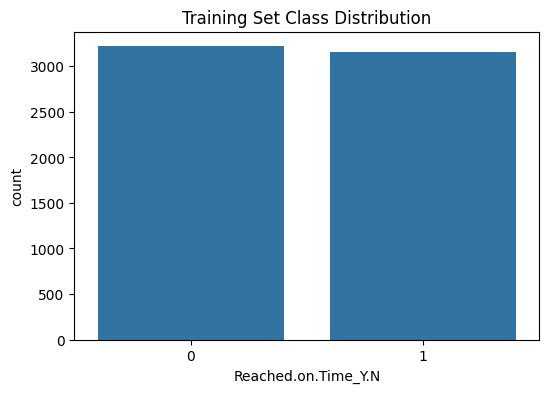

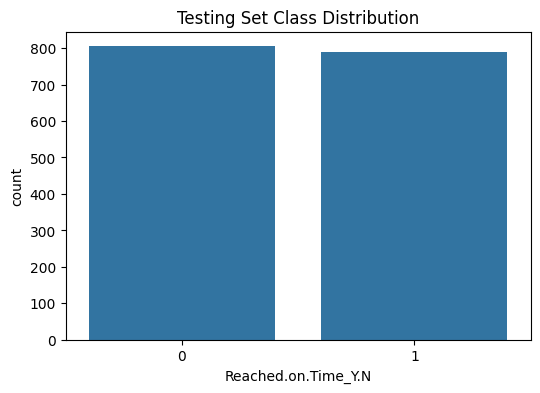

In [24]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_train)
plt.title("Training Set Class Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x=y_test)
plt.title("Testing Set Class Distribution")
plt.show()



# Save training and testing data into separate CSV files


In [25]:
# Combine features and target for saving
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Save to CSV files
train_data.to_csv("ShipmentSure_Train_Data.csv", index=False)
test_data.to_csv("ShipmentSure_Test_Data.csv", index=False)

print("Training and Testing datasets saved successfully!")


Training and Testing datasets saved successfully!


# Handle Class Imbalance using SMOTE

In [26]:

# Check original class distribution
print("Before SMOTE class distribution:", Counter(y_train))
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply to training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


Before SMOTE class distribution: Counter({0: 3219, 1: 3157})


After SMOTE class distribution: Counter({1: 3219, 0: 3219})


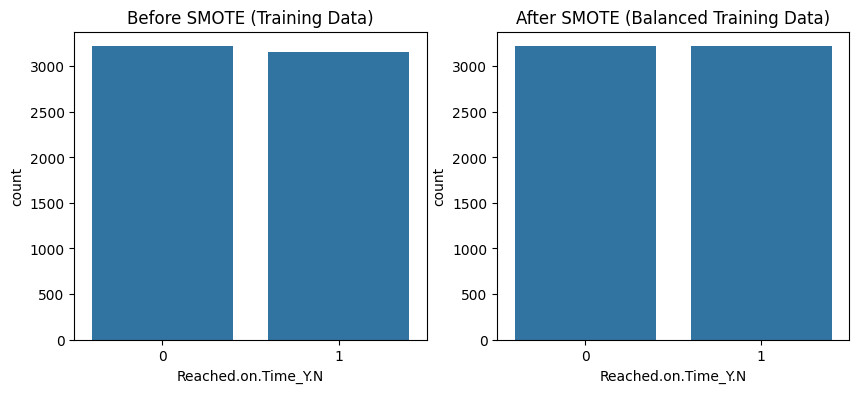

In [27]:

# Check new class distribution
print("After SMOTE class distribution:", Counter(y_train_resampled))
# Visualization before & after
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(x=y_train, ax=ax[0])
ax[0].set_title("Before SMOTE (Training Data)")
sns.countplot(x=y_train_resampled, ax=ax[1])
ax[1].set_title("After SMOTE (Balanced Training Data)")
plt.show()


In [28]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
models = {
    "Logistic Regression": LogisticRegression(C=0.5, max_iter=1000, random_state=42),  # L2 regularization (smaller C = stronger)
    
    "Decision Tree": DecisionTreeClassifier(max_depth=8, min_samples_split=10, min_samples_leaf=5, random_state=42),
    
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42, n_jobs=-1),
    
    "Naive Bayes": GaussianNB(),
    
    "KNN": KNeighborsClassifier(n_neighbors=9),  # more neighbors → smoother, less overfitting
    
    "SVM": SVC(C=0.5, kernel='rbf', gamma='scale', random_state=42),
    
    "XGBoost": XGBClassifier(
        learning_rate=0.05, n_estimators=500, max_depth=6,subsample=0.8, colsample_bytree=0.8, reg_lambda=0.5, use_label_encoder=False, eval_metric='logloss', random_state=42),
    
    "LightGBM": LGBMClassifier(
        learning_rate=0.05, n_estimators=500, max_depth=6,num_leaves=20, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.2, reg_lambda=0.5, random_state=42),
    
    "CatBoost": CatBoostClassifier(
        iterations=500, learning_rate=0.05, depth=6, l2_leaf_reg=5, verbose=False, random_state=42)
}


In [29]:
results = []

for name, model in models.items():
    pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
    
    # Cross-validation accuracy (10-fold)
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    
    results.append({
        'Model': name,
        'Mean CV Accuracy': round(np.mean(cv_scores), 4),
        'Std Dev': round(np.std(cv_scores), 4)
    })
results_df = pd.DataFrame(results).sort_values(by='Mean CV Accuracy', ascending=False)
print("\n Cross-validation results (Overfitting check):")
print(results_df)



 Cross-validation results (Overfitting check):
                 Model  Mean CV Accuracy  Std Dev
2        Random Forest            0.5944   0.0173
1        Decision Tree            0.5866   0.0179
5                  SVM            0.5863   0.0168
8             CatBoost            0.5764   0.0175
0  Logistic Regression            0.5757   0.0198
7             LightGBM            0.5734   0.0177
3          Naive Bayes            0.5676   0.0170
6              XGBoost            0.5634   0.0260
4                  KNN            0.5460   0.0161


In [30]:
# Fix random seed for consistency
RND = 42
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RND)

# Define models with anti-overfitting hyperparameters
models = {
    "Logistic Regression": LogisticRegression(C=0.1, penalty='l2', solver='liblinear', random_state=RND),
    "Decision Tree": DecisionTreeClassifier(max_depth=6, min_samples_split=10, min_samples_leaf=4, random_state=RND),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, 
                                            min_samples_leaf=3, max_features='sqrt', random_state=RND),
    "KNN": KNeighborsClassifier(n_neighbors=15),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(C=0.5, kernel='rbf', gamma='scale', random_state=RND),
    "XGBoost": XGBClassifier(max_depth=4, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
                             reg_lambda=1, n_estimators=200, random_state=RND, eval_metric='logloss', use_label_encoder=False),
    "LightGBM": LGBMClassifier(num_leaves=20, max_depth=6, subsample=0.8, reg_lambda=0.5,
                               learning_rate=0.05, n_estimators=200, random_state=RND),
    "CatBoost": CatBoostClassifier(depth=6, learning_rate=0.05, l2_leaf_reg=3, n_estimators=200,
                                   verbose=0, random_state=RND)
}
# Run cross-validation to check improvement
cv_results = []
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

    cv_results.append({
        "Model": name,
        "Mean CV Accuracy": np.mean(scores),
        "Std Dev": np.std(scores)
    })


[LightGBM] [Info] Number of positive: 2841, number of negative: 2897
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1282
[LightGBM] [Info] Number of data points in the train set: 5738, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495120 -> initscore=-0.019520
[LightGBM] [Info] Start training from score -0.019520
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [31]:
# Display results
cv_df = pd.DataFrame(cv_results).sort_values(by="Mean CV Accuracy", ascending=False)
print("\nCross-validation results (After Regularization to Fix Overfitting):")
print(cv_df.to_string(index=False))


Cross-validation results (After Regularization to Fix Overfitting):
              Model  Mean CV Accuracy  Std Dev
      Random Forest          0.592222 0.012717
           CatBoost          0.590183 0.017971
      Decision Tree          0.589712 0.016487
            XGBoost          0.589089 0.020993
           LightGBM          0.588772 0.014034
Logistic Regression          0.573244 0.016117
        Naive Bayes          0.568540 0.012777
                SVM          0.550349 0.016596
                KNN          0.538270 0.014653



 Training and evaluating Logistic Regression...

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.57      0.61      0.59       644
           1       0.57      0.53      0.55       632

    accuracy                           0.57      1276
   macro avg       0.57      0.57      0.57      1276
weighted avg       0.57      0.57      0.57      1276


 Training and evaluating Decision Tree...

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.60      0.90      0.72       644
           1       0.80      0.40      0.53       632

    accuracy                           0.65      1276
   macro avg       0.70      0.65      0.63      1276
weighted avg       0.70      0.65      0.63      1276


 Training and evaluating Random Forest...

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.66 

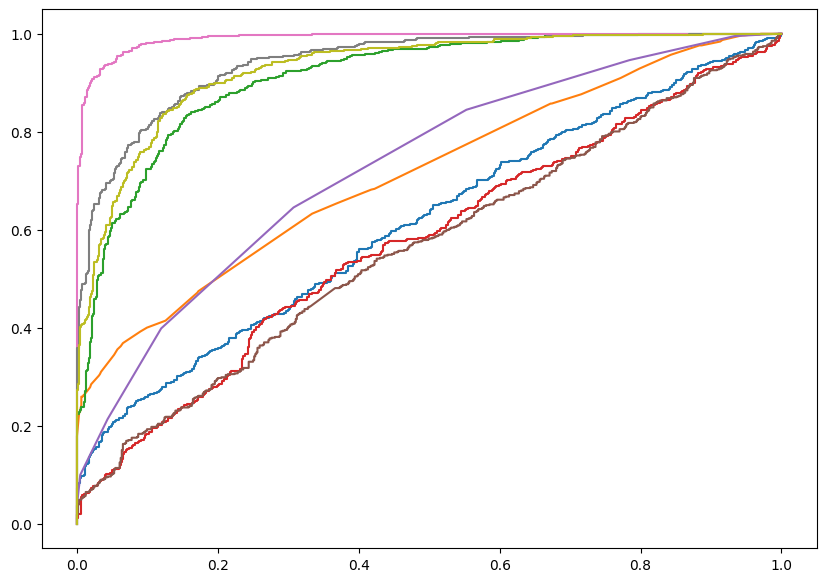

In [32]:
models = {
    "Logistic Regression": LogisticRegression(C=0.5, max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=8, min_samples_split=10, min_samples_leaf=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42, n_jobs=-1),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=9),
    "SVM": SVC(C=0.5, kernel='rbf', gamma='scale', probability=True, random_state=42),
    "XGBoost": XGBClassifier(
        learning_rate=0.05, n_estimators=500, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=0.5,
        use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(
        learning_rate=0.05, n_estimators=500, max_depth=6, num_leaves=20,
        subsample=0.8, colsample_bytree=0.8, reg_alpha=0.2, reg_lambda=0.5, random_state=42),
    "CatBoost": CatBoostClassifier(
        iterations=500, learning_rate=0.05, depth=6, l2_leaf_reg=5, verbose=False, random_state=42)
}
# Store results
results = {}
comparison = []

plt.figure(figsize=(10, 7))
for name, model in models.items():
    print(f"\n Training and evaluating {name}...")
    
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    y_val_prob = model.predict_proba(X_val)[:, 1]
    
    # Metrics
    acc = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred)
    rec = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    roc_auc = roc_auc_score(y_val, y_val_prob)
    
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_val, y_val_pred))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_val_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
    
    comparison.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1 Score": round(f1, 4),
        "ROC-AUC": round(roc_auc, 4)
    })


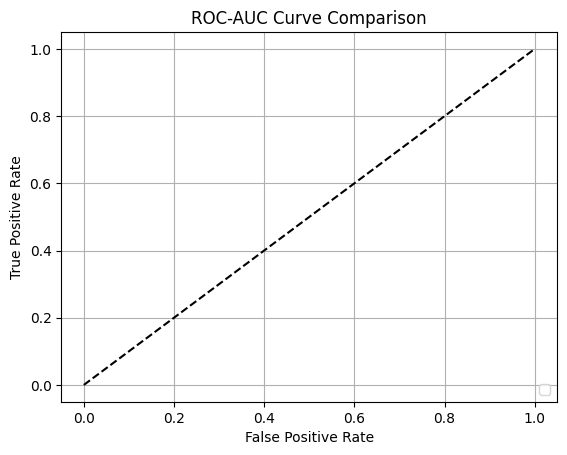


Final Model Comparison Table:
                 Model  Accuracy  Precision  Recall  F1 Score  ROC-AUC
6              XGBoost    0.9428     0.9713  0.9114    0.9404   0.9907
7             LightGBM    0.8378     0.9242  0.7326    0.8173   0.9420
8             CatBoost    0.8111     0.9151  0.6820    0.7815   0.9289
2        Random Forest    0.7367     0.9458  0.4968    0.6515   0.9114
4                  KNN    0.6693     0.6733  0.6456    0.6591   0.7292
1        Decision Tree    0.6528     0.7981  0.4003    0.5332   0.7137
0  Logistic Regression    0.5690     0.5697  0.5301    0.5492   0.6137
3          Naive Bayes    0.5768     0.6045  0.4209    0.4963   0.5761
5                  SVM    0.5517     0.5673  0.4003    0.4694   0.5647


In [33]:

# ROC Curve 
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC-AUC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
# Final Comparison Table
comparison_df = pd.DataFrame(comparison).sort_values(by='ROC-AUC', ascending=False)
print("\nFinal Model Comparison Table:")
print(comparison_df)



Training and Evaluating: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.61      0.59       644
           1       0.57      0.53      0.55       632

    accuracy                           0.57      1276
   macro avg       0.57      0.57      0.57      1276
weighted avg       0.57      0.57      0.57      1276



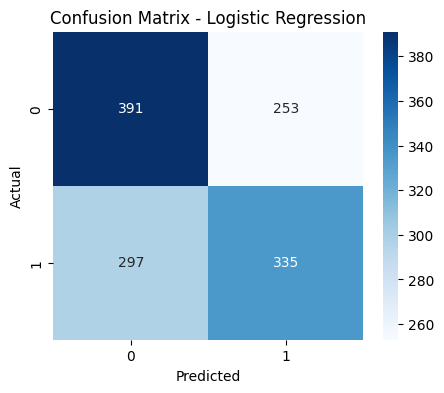

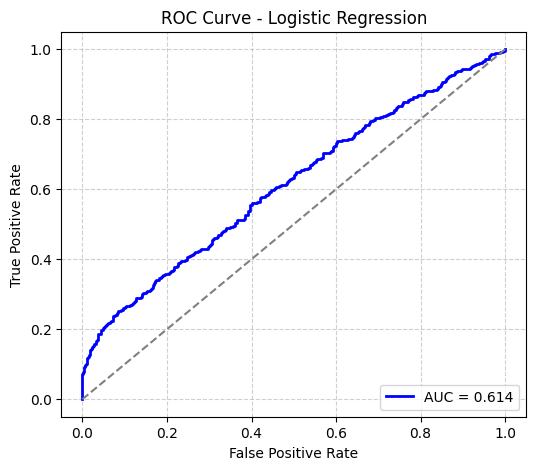


Training and Evaluating: Decision Tree

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.90      0.72       644
           1       0.80      0.40      0.53       632

    accuracy                           0.65      1276
   macro avg       0.70      0.65      0.63      1276
weighted avg       0.70      0.65      0.63      1276



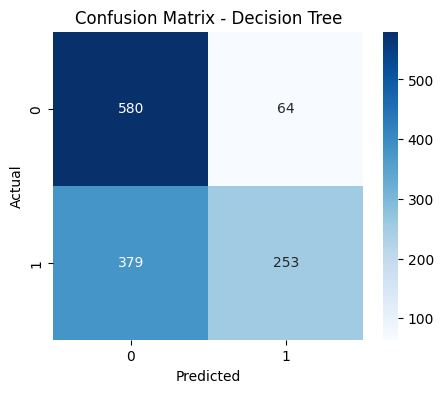

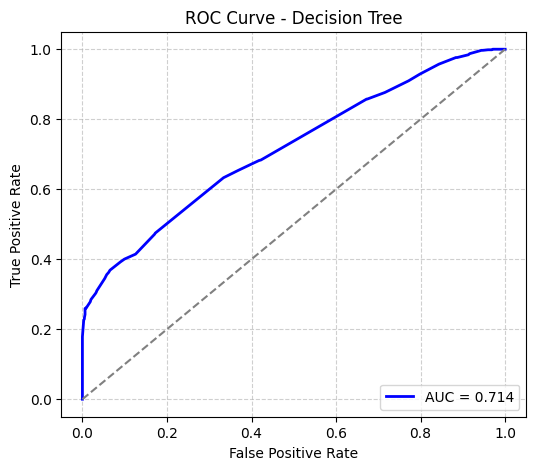


Training and Evaluating: Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.97      0.79       644
           1       0.95      0.50      0.65       632

    accuracy                           0.74      1276
   macro avg       0.80      0.73      0.72      1276
weighted avg       0.80      0.74      0.72      1276



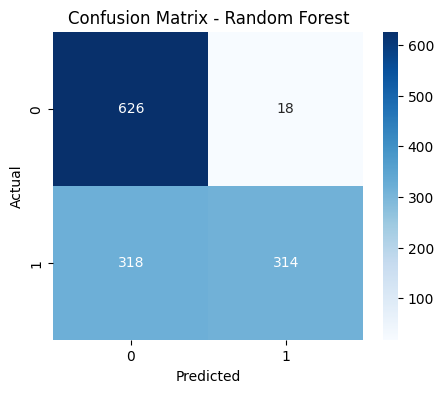

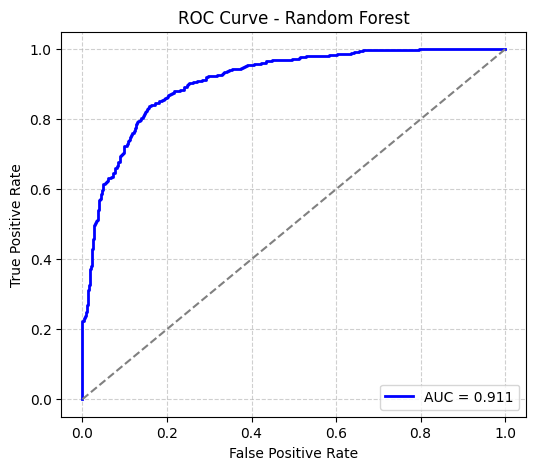


Training and Evaluating: Naive Bayes

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.73      0.64       644
           1       0.60      0.42      0.50       632

    accuracy                           0.58      1276
   macro avg       0.58      0.58      0.57      1276
weighted avg       0.58      0.58      0.57      1276



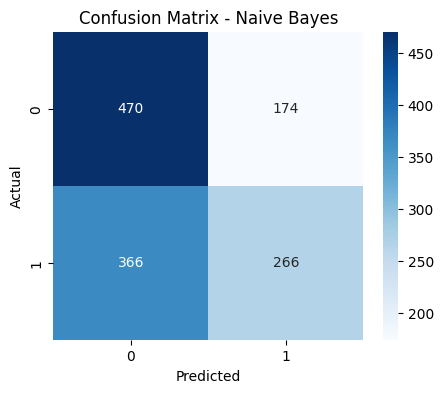

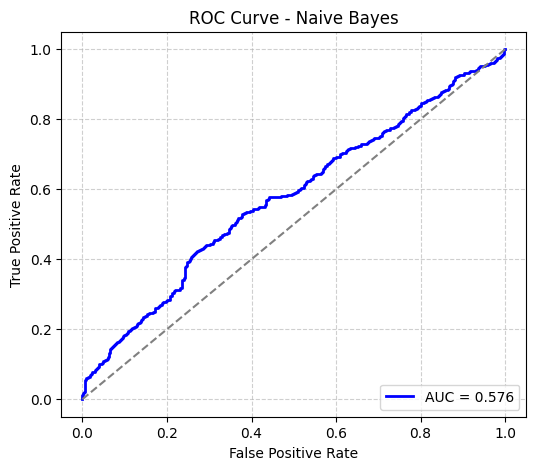


Training and Evaluating: KNN

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       644
           1       0.67      0.65      0.66       632

    accuracy                           0.67      1276
   macro avg       0.67      0.67      0.67      1276
weighted avg       0.67      0.67      0.67      1276



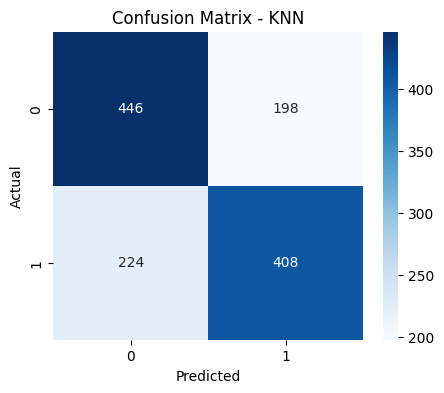

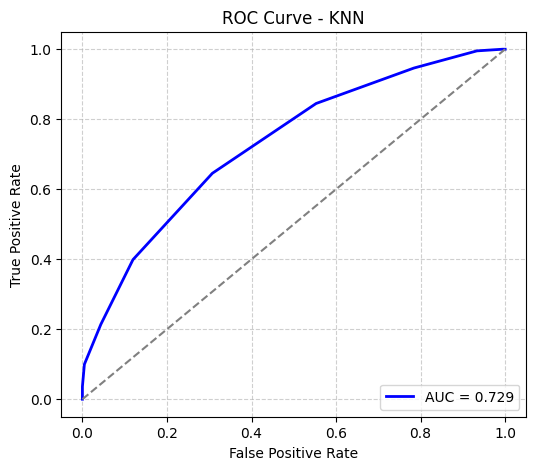


Training and Evaluating: SVM

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.70      0.61       644
           1       0.57      0.40      0.47       632

    accuracy                           0.55      1276
   macro avg       0.56      0.55      0.54      1276
weighted avg       0.56      0.55      0.54      1276



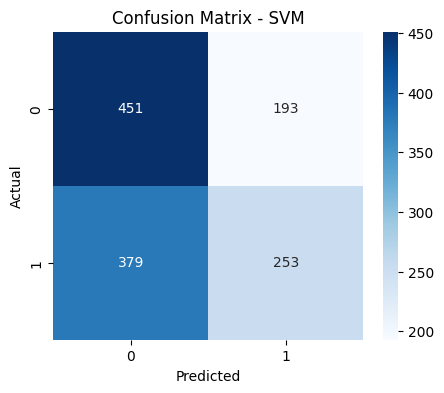

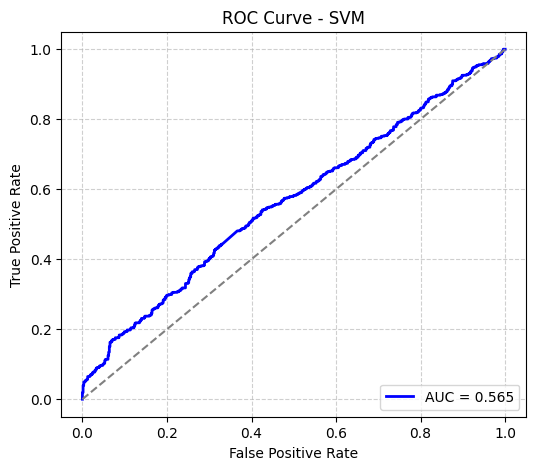


Training and Evaluating: XGBoost

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       644
           1       0.97      0.91      0.94       632

    accuracy                           0.94      1276
   macro avg       0.94      0.94      0.94      1276
weighted avg       0.94      0.94      0.94      1276



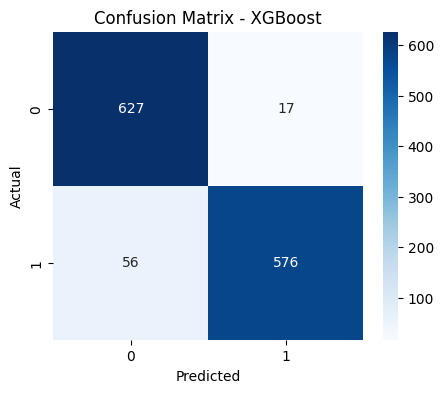

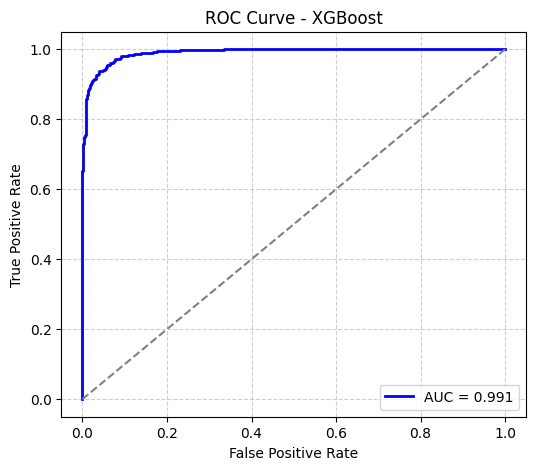


Training and Evaluating: LightGBM
[LightGBM] [Info] Number of positive: 3157, number of negative: 3219
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1284
[LightGBM] [Info] Number of data points in the train set: 6376, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495138 -> initscore=-0.019449
[LightGBM] [Info] Start training from score -0.019449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

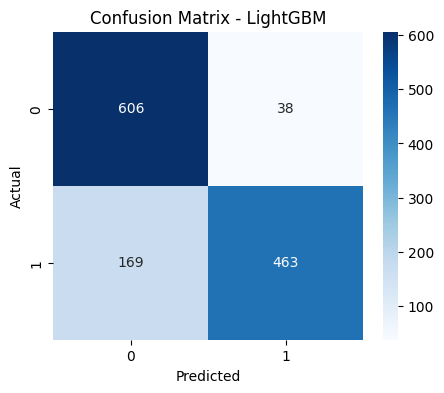

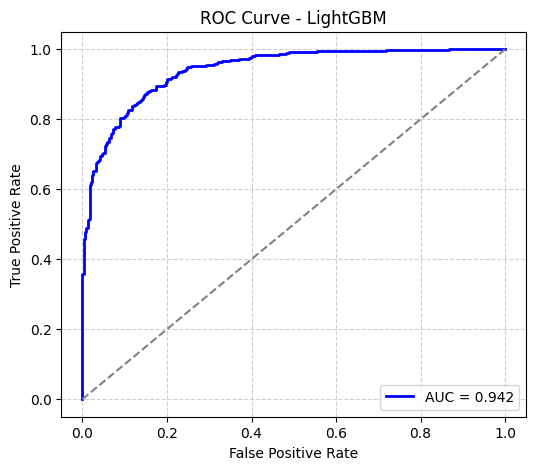


Training and Evaluating: CatBoost

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.94      0.83       644
           1       0.92      0.68      0.78       632

    accuracy                           0.81      1276
   macro avg       0.83      0.81      0.81      1276
weighted avg       0.83      0.81      0.81      1276



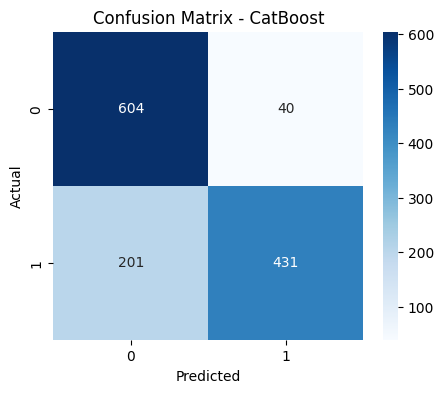

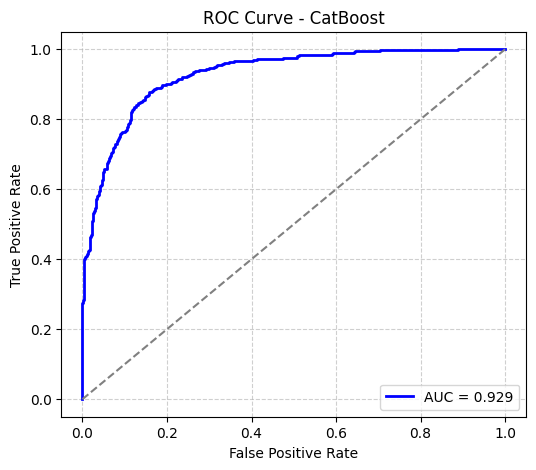

In [34]:
models = {
    "Logistic Regression": LogisticRegression(C=0.5, max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=8, min_samples_split=10, min_samples_leaf=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42, n_jobs=-1),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=9),
    "SVM": SVC(C=0.5, kernel='rbf', gamma='scale', probability=True, random_state=42),
    "XGBoost": XGBClassifier(
        learning_rate=0.05, n_estimators=500, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=0.5,
        use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(
        learning_rate=0.05, n_estimators=500, max_depth=6, num_leaves=20,
        subsample=0.8, colsample_bytree=0.8, reg_alpha=0.2, reg_lambda=0.5, random_state=42),
    "CatBoost": CatBoostClassifier(
        iterations=500, learning_rate=0.05, depth=6, l2_leaf_reg=5, verbose=False, random_state=42)
}
comparison = []

for name, model in models.items():
    print(f"\nTraining and Evaluating: {name}")
    
    
    # Train model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]
    
    # Metrics
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_prob)

    
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))
    
    
    plt.figure(figsize=(5,4))
    sns.heatmap(pd.crosstab(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    

    fpr, tpr, _ = roc_curve(y_val, y_prob)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f"ROC Curve - {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # Store Results
    comparison.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1 Score": round(f1, 4),
        "ROC-AUC": round(roc_auc, 4)
    })


In [35]:
comparison_df = pd.DataFrame(comparison).sort_values(by="ROC-AUC", ascending=False)
print("\nFinal Model Comparison Table:")
print(comparison_df)
# Save XGBoost model (from the models dictionary)
joblib.dump(models["XGBoost"], "best_model_XGBoost.joblib")
print("XGBoost model saved successfully!")



Final Model Comparison Table:
                 Model  Accuracy  Precision  Recall  F1 Score  ROC-AUC
6              XGBoost    0.9428     0.9713  0.9114    0.9404   0.9907
7             LightGBM    0.8378     0.9242  0.7326    0.8173   0.9420
8             CatBoost    0.8111     0.9151  0.6820    0.7815   0.9289
2        Random Forest    0.7367     0.9458  0.4968    0.6515   0.9114
4                  KNN    0.6693     0.6733  0.6456    0.6591   0.7292
1        Decision Tree    0.6528     0.7981  0.4003    0.5332   0.7137
0  Logistic Regression    0.5690     0.5697  0.5301    0.5492   0.6137
3          Naive Bayes    0.5768     0.6045  0.4209    0.4963   0.5761
5                  SVM    0.5517     0.5673  0.4003    0.4694   0.5647
XGBoost model saved successfully!


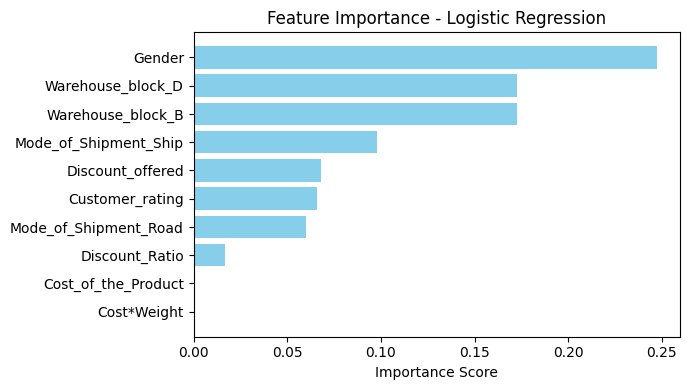

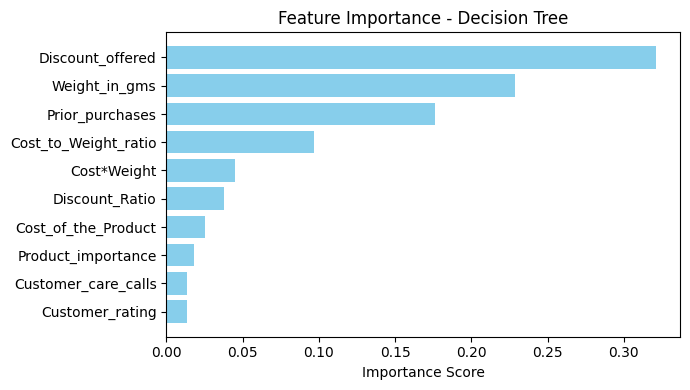

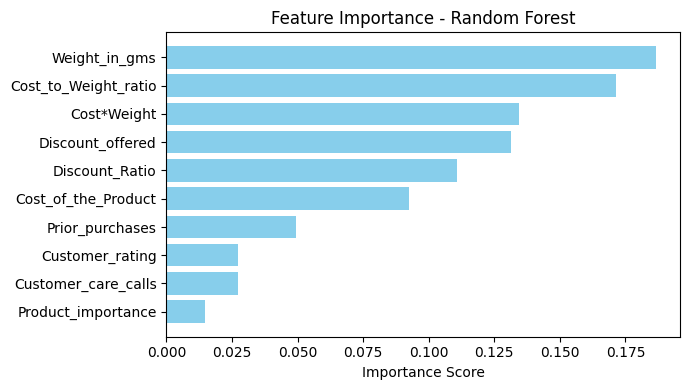

Naive Bayes does not support feature importance.
KNN does not support feature importance.
SVM does not support feature importance.


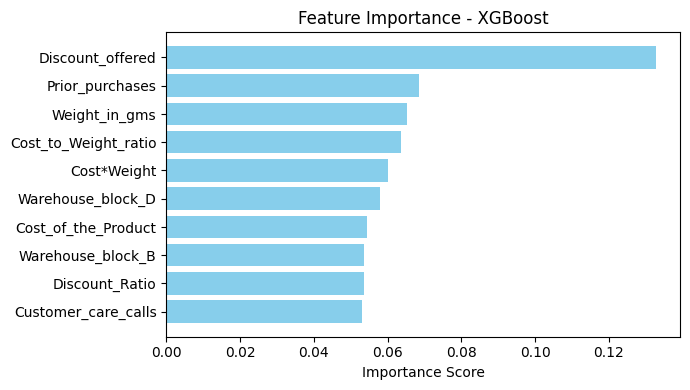

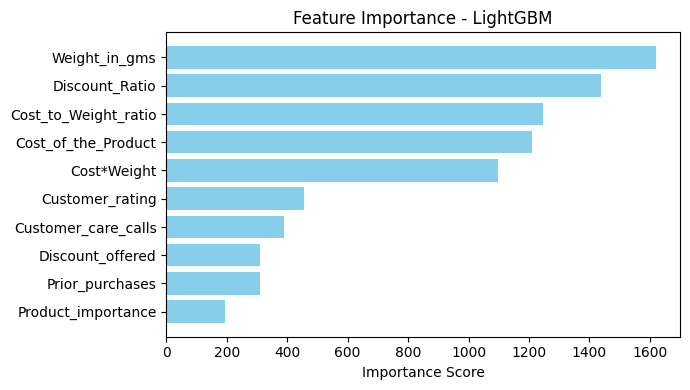

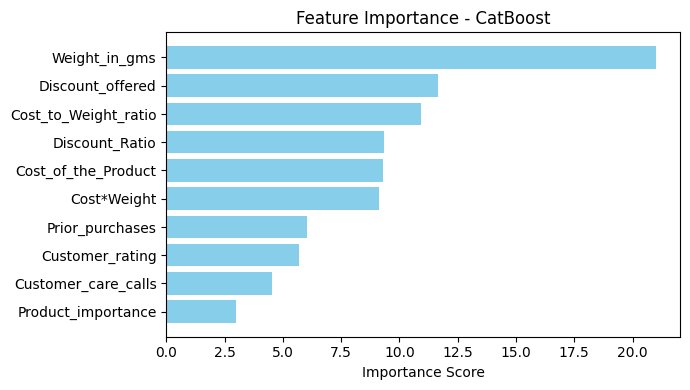


Top 10 Most Important Features Across All Models:

                      Logistic Regression  Decision Tree  Random Forest  \
Weight_in_gms                1.810520e-04       0.228563       0.186480   
Discount_Ratio               1.675248e-02       0.038089       0.110649   
Cost_to_Weight_ratio         4.188513e-02       0.096820       0.171463   
Cost_of_the_Product          1.433510e-04       0.025363       0.092575   
Cost*Weight                  5.809321e-08       0.045164       0.134511   
Customer_rating              6.607612e-02       0.013381       0.027402   
Customer_care_calls          4.795747e-02       0.013396       0.027227   
Discount_offered             6.808305e-02       0.320849       0.131455   
Prior_purchases              1.261371e-01       0.176502       0.049456   
Product_importance           1.483530e-02       0.018016       0.014874   

                       XGBoost  LightGBM   CatBoost  Average_Importance  
Weight_in_gms         0.065385      1619  20.984

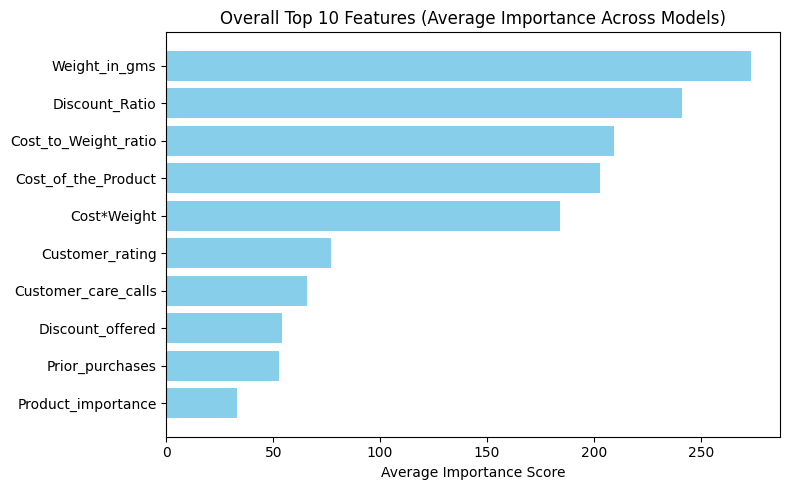

In [36]:
feature_names = X_train.columns

def plot_feature_importance(model, model_name):
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
    elif hasattr(model, "coef_"):
        importance = model.coef_[0]
    else:
        print(f"{model_name} does not support feature importance.")
        return
    
    imp_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importance
    }).sort_values(by="Importance", ascending=False).head(10)
    
    plt.figure(figsize=(7,4))
    plt.barh(imp_df["Feature"], imp_df["Importance"], color="skyblue")
    plt.gca().invert_yaxis()
    plt.title(f"Feature Importance - {model_name}")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()

# Loop directly over your existing models
for name, model in models.items():
    plot_feature_importance(model, name)

# Only include models that support feature importance or coefficients
supported_models = {name: model for name, model in models.items() 
                    if hasattr(model, "feature_importances_") or hasattr(model, "coef_")}

feature_names = X_train.columns

# Store importance values for each model
importance_df = pd.DataFrame(index=feature_names)

for name, model in supported_models.items():
    if hasattr(model, "feature_importances_"):
        importance_df[name] = model.feature_importances_
    elif hasattr(model, "coef_"):
        importance_df[name] = np.abs(model.coef_[0])  # use absolute values for coefficients

# Compute average importance across models
importance_df["Average_Importance"] = importance_df.mean(axis=1)

# Sort by average importance
top_features = importance_df.sort_values(by="Average_Importance", ascending=False).head(10)

# Display table
print("\nTop 10 Most Important Features Across All Models:\n")
print(top_features)

# Plot
plt.figure(figsize=(8,5))
plt.barh(top_features.index, top_features["Average_Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.title("Overall Top 10 Features (Average Importance Across Models)")
plt.xlabel("Average Importance Score")
plt.tight_layout()
plt.show()


In [42]:
import joblib

# Load the saved training columns
train_columns = joblib.load("X_train_columns.joblib")

# Print all column names
print("Columns used during training:")
for col in train_columns:
    print(col)

# Or just see them as a list
print("\nAll columns as a list:")
print(list(train_columns))



Columns used during training:
Customer_care_calls
Customer_rating
Cost_of_the_Product
Prior_purchases
Product_importance
Gender
Discount_offered
Weight_in_gms
Warehouse_block_B
Warehouse_block_C
Warehouse_block_D
Warehouse_block_F
Mode_of_Shipment_Road
Mode_of_Shipment_Ship
Cost_to_Weight_ratio
Cost*Weight
Discount_Ratio

All columns as a list:
['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms', 'Warehouse_block_B', 'Warehouse_block_C', 'Warehouse_block_D', 'Warehouse_block_F', 'Mode_of_Shipment_Road', 'Mode_of_Shipment_Ship', 'Cost_to_Weight_ratio', 'Cost*Weight', 'Discount_Ratio']
